In [35]:
import librosa
import json
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import SpectralClustering


def dict_morse_to_text():
    # loading dictionary with translated letters to morse code
    with open('./data/morse_code.json', "r", encoding='utf-8') as file:
        morse_code = json.load(file)
    from_morse = {}
    for key, value in morse_code.items():
        from_morse[value] = key
    # print(from_morse)
    return from_morse


#  translating sentances into morse code
def translator_from_morse(text):
    from_morse = dict_morse_to_text()
    return " ".join(["".join([from_morse.get("".join(sign.split(","))) for sign in word.split("_")]) for word in text.split(" ")])


def dict_class_to_morse(cluster_centers):
    dict = {}
    print(cluster_centers)
    if len(cluster_centers) == 1:
        dict[0] = '.'
    if len(cluster_centers[cluster_centers > 0]) == 1 and len(cluster_centers[cluster_centers < 0]) == 1:
        dict[0] = ','
        dict[1] = '.'
    elif len(cluster_centers[cluster_centers > 0]) == 1 and len(cluster_centers[cluster_centers < 0]) == 2:
        if (abs(cluster_centers[1]) - cluster_centers[2])**2 < (abs(cluster_centers[0]) - cluster_centers[2])**2:
        # if abs(cluster_centers[0]) > cluster_centers[cluster_centers>0][0]>abs(cluster_centers[1]):
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '.'
        # elif abs(cluster_centers[0]) < cluster_centers[cluster_centers>0][0]:
        else:
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '-'
    elif len(cluster_centers[cluster_centers > 0]) == 2 and len(cluster_centers[cluster_centers < 0]) == 1:
        if (abs(cluster_centers[0]) - cluster_centers[1])**2 < (abs(cluster_centers[0]) - cluster_centers[2])**2:
            dict[0] = ','
            dict[1] = '.'
            dict[2] = '-'
        elif (abs(cluster_centers[0])-cluster_centers[2])**2 < cluster_centers[cluster_centers>0][0]**2:
            dict[0] = '_'
            dict[1] = '.'
            dict[2] = '-'
        else:
            dict[0] = ' '
            dict[1] = '.'
            dict[2] = '-'
    elif len(cluster_centers[cluster_centers > 0]) == 2 and len(cluster_centers[cluster_centers < 0]) == 2:
        print(cluster_centers)
        if (abs(cluster_centers[0]) - cluster_centers[cluster_centers>0][1])**2  > cluster_centers[cluster_centers>0][0]**2 and (abs(cluster_centers[1]) - cluster_centers[cluster_centers>0][1])**2  < cluster_centers[cluster_centers>0][0]**2:
            dict[0] = ' '
            dict[1] = '_'
            dict[2] = '.'
            dict[3] = '-'
        if (abs(cluster_centers[0]) - cluster_centers[cluster_centers>0][1])**2  > cluster_centers[cluster_centers>0][0]**2 and (abs(cluster_centers[1]) - cluster_centers[cluster_centers>0][1])**2  > cluster_centers[cluster_centers>0][0]**2:
            dict[0] = ' '
            dict[1] = ','
            dict[2] = '.'
            dict[3] = '-'
        else:
            print("opcja 2")
            dict[0] = '_'
            dict[1] = ','
            dict[2] = '.'
            dict[3] = '-'

    elif len(cluster_centers) == 5:
        dict[0] = ' '
        dict[1] = '_'
        dict[2] = ','
        dict[3] = '.'
        dict[4] = '-'
    return dict


def sound_translator(path):
    samples, sampling_rate = librosa.load(path, sr=10000, mono=True, offset=0.0
                        , duration=None)
    print(samples)
    max_abs_scaler = preprocessing.MaxAbsScaler()
    new_samples = max_abs_scaler.fit_transform(np.array(samples).reshape(1,-1).T)
    # new_samples = ((pd.Series(samples) - min(samples)) * (1 - (-1))) / (max(samples) - min(samples)) + (-1)
    threshold =np.mean(list(map(lambda i: abs(i), new_samples)))
    bin_samples = [1 if abs(new_val)>threshold else 0 for new_val in new_samples]
    bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
    bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
    border = 100
    new_bin_samples =  [1 for i in range(border)] + \
    [(1 if (bin_samples[i] ==1 or (np.sum(bin_samples[i-border:i]) > 0 and np.sum(bin_samples[i:i+border]) > 0)) else 0) \
     for i in list(range(border, len(bin_samples)-border))] + \
          [1 for i in range(border)]
    
    new_list = []
    k = 0
    for i in range(len(new_bin_samples)-1):
        if new_bin_samples[i] != new_bin_samples[i+1]:
            if new_bin_samples[i] == 1:
                new_list.append(i-k+1)
            else:
                new_list.append(-(i+1-k))
            k = i 
    new_list.append(len(new_bin_samples)-k)
    # new_list = [i for i in new_list if abs(i)>max(new_list)/10]
    new_list = [i for i in new_list if abs(i)>100]
    scaler = StandardScaler()
    scaled = scaler.fit_transform(np.array([i for i in new_list]).reshape(1,-1).T)
    silhouette_coefficients = []
    if(len(scaled)>1):
        for k in range(2, 6):
            if(len(scaled)>k):
                clustering = SpectralClustering(n_clusters=k).fit(scaled)
                score = silhouette_score(scaled, clustering.labels_)
                silhouette_coefficients.append(score)
                print(score)

        print(silhouette_coefficients)
        n_clust = silhouette_coefficients.index(max(silhouette_coefficients))+2
        clustering = SpectralClustering(n_clusters=n_clust)
        clustering.fit(scaled)
        
        df = pd.DataFrame(columns = ['length', 'class'])
        df['length'] = new_list
        df['class'] = clustering.labels_
    else:
        n_clust = 1
        df = pd.DataFrame(columns = ['length', 'class'])
        df['length'] = new_list
        df['class'] = 0

    cB0 =df['class']
    ord_idx=np.argsort(df.groupby(['class']).mean()['length'])
    cntrs = np.zeros_like(cB0)-1
    for i in np.arange(n_clust):
        cntrs[cB0==ord_idx[i]]=i

    df = pd.DataFrame(columns = ['length', 'class'])
    df['length'] = new_list
    df['class'] = cntrs
    dict = dict_class_to_morse(np.array([np.sort(df.groupby(['class']).mean()['length'])]).T)
    # print(df['class'])
    # print("".join([dict.get(i) for i in df['class']]))
    try:
        return translator_from_morse("".join([dict.get(i) for i in df['class']])) 
    except:
        return "Cant translate sound"

In [36]:
import matplotlib.pyplot as plt

0.819776859033219
0.7075745161391735
0.9200358132911689
0.6927505521188368
[0.819776859033219, 0.7075745161391735, 0.9200358132911689, 0.6927505521188368]


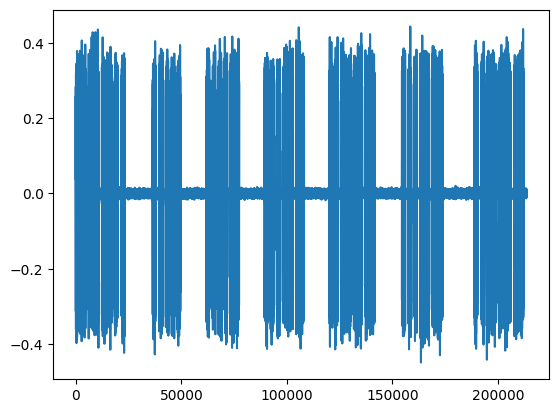

In [37]:
samples, sampling_rate = librosa.load('/Users/zuzannaglinka/gcpBackend/test_tmp/beep-04_0.wav', sr=10000, mono=True, offset=0.0
                    , duration=None)
plt.plot(samples)
max_abs_scaler = preprocessing.MaxAbsScaler()
new_samples = max_abs_scaler.fit_transform(np.array(samples).reshape(1,-1).T)
# new_samples = ((pd.Series(samples) - min(samples)) * (1 - (-1))) / (max(samples) - min(samples)) + (-1)
threshold =np.mean(list(map(lambda i: abs(i), new_samples)))
bin_samples = [1 if abs(new_val)>threshold else 0 for new_val in new_samples]
bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
bin_samples = bin_samples[bin_samples.index(1):max([i for i ,e in enumerate(bin_samples) if e == 1])+1]
border = 100
new_bin_samples =  [1 for i in range(border)] + \
[(1 if (bin_samples[i] ==1 or (np.sum(bin_samples[i-border:i]) > 0 and np.sum(bin_samples[i:i+border]) > 0)) else 0) \
    for i in list(range(border, len(bin_samples)-border))] + \
        [1 for i in range(border)]

new_list = []
k = 0
for i in range(len(new_bin_samples)-1):
    if new_bin_samples[i] != new_bin_samples[i+1]:
        if new_bin_samples[i] == 1:
            new_list.append(i-k+1)
        else:
            new_list.append(-(i+1-k))
        k = i 
new_list.append(len(new_bin_samples)-k)
# new_list = [i for i in new_list if abs(i)>max(new_list)/10]
new_list = [i for i in new_list if abs(i)>100]
scaler = StandardScaler()
scaled = scaler.fit_transform(np.array([i for i in new_list]).reshape(1,-1).T)
silhouette_coefficients = []
if(len(scaled)>1):
    for k in range(2, 6):
        if(len(scaled)>k):
            clustering = SpectralClustering(n_clusters=k).fit(scaled)
            score = silhouette_score(scaled, clustering.labels_)
            silhouette_coefficients.append(score)
            print(score)

    print(silhouette_coefficients)
    n_clust = silhouette_coefficients.index(max(silhouette_coefficients))+2
    clustering = SpectralClustering(n_clusters=n_clust)
    clustering.fit(scaled)
    
    df = pd.DataFrame(columns = ['length', 'class'])
    df['length'] = new_list
    df['class'] = clustering.labels_
else:
    n_clust = 1
    df = pd.DataFrame(columns = ['length', 'class'])
    df['length'] = new_list
    df['class'] = 0


In [38]:
df

,length,class
0,4603,3
1,-1490,2
2,4876,3
3,-1399,2
4,4672,3
...,...,...
64,4553,3
65,-1357,2
66,5476,3
67,-1545,2


In [39]:

cB0 =df['class']
ord_idx=np.argsort(df.groupby(['class']).mean()['length'])
cntrs = np.zeros_like(cB0)-1
for i in np.arange(n_clust):
    cntrs[cB0==ord_idx[i]]=i

df = pd.DataFrame(columns = ['length', 'class'])
df['length'] = new_list
df['class'] = cntrs
dict = dict_class_to_morse(np.array([np.sort(df.groupby(['class']).mean()['length'])]).T)
# print(df['class'])
# print("".join([dict.get(i) for i in df['class']]))


[[-12983.66666667]
 [ -1456.85714286]
 [  1424.14285714]
 [  4530.64285714]]


In [40]:
dict

{0: ' ', 1: ',', 2: '.', 3: '-'}

In [41]:
"".join([dict.get(i) for i in df['class']])

'-,-,-,.,. .,.,.,.,. .,.,.,.,- .,.,.,-,- .,.,-,-,- .,.,.,-,- .,.,-,-,-'

In [42]:
translator_from_morse('.,.,.,.,.')

'5'

In [43]:
translator_from_morse("".join([dict.get(i) for i in df['class']])) 

'8 5 4 3 2 3 2'